In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as f
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from model import Net

net = Net()
print(net)

Net(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (conv5): Conv2d(256, 512, kernel_size=(1, 1), stride=(1, 1))
  (fc1): Linear(in_features=18432, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=8, bias=True)
  (drop1): Dropout(p=0.25, inplace=False)
)


In [2]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

In [3]:
annotations = pd.read_csv('../data/AFLW/annotations.csv')

In [4]:
annotations.shape

(16418, 12)

In [5]:
annotations.rename(columns={"Unnamed: 0": "index"}, inplace=True)
annotations.head()

,index,face_id,LeftEye_x,LeftEye_y,RightEye_x,RightEye_y,Nose_x,Nose_y,Mouth_x,Mouth_y,file_id,sex
0,0,39341,209.0,150.0,302.0,186.0,277.000000,268.000000,232.000000,308.000000,image00035.jpg,m
1,1,39343,148.0,203.0,234.0,207.0,219.053909,272.376251,203.000000,308.000000,image00168.jpg,f
2,2,39348,143.0,123.0,223.0,173.0,159.983505,209.756149,134.000000,257.000000,image00102.jpg,f
3,3,39349,229.0,196.0,291.0,198.0,274.000000,218.000000,270.000000,254.000000,image00104.jpg,f
4,4,39352,334.0,229.0,526.0,249.0,486.200958,406.574982,433.417664,518.424988,image00122.jpg,f


In [6]:
from dotenv import load_dotenv
import os

load_dotenv()

dataset_path = os.getenv("DATA_PATH")

In [7]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

class FaceKeypointDataset(Dataset):
    def __init__(self, annotations, root_dir, transform=None):
        
        self.annotations = annotations
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        try:
            img_name = os.path.join(self.root_dir, self.annotations["file_id"][idx])
            image = plt.imread(img_name)
            
            if len(image.shape) == 2:
                image = np.stack([image] * 3, axis=-1)
            elif image.shape[-1] == 4:
                image = image[:, :, :3]
            elif image.shape[-1] != 3:
                raise ValueError(f"Unexpected number of channels: {image.shape[-1]} in {img_name}")

            landmarks = self.annotations.iloc[idx, 2:-2].values
            landmarks = landmarks.astype('float').reshape(-1, 2)

            if self.transform:
                image = self.transform(image)

            h, w = image.shape[1:]
            landmarks[:, 0] *= (224 / w)
            landmarks[:, 1] *= (224 / h)

            return image, torch.tensor(landmarks, dtype=torch.float32)

        except Exception as e:
            print(f"Skipping {idx} due to error: {e}")
            return None

In [8]:
annotations.iloc[0, 2:10].values

array([np.float64(209.0), np.float64(150.0), np.float64(302.0),
       np.float64(186.0), np.float64(277.0), np.float64(268.0),
       np.float64(232.0), np.float64(308.0)], dtype=object)

In [9]:
os.path.join(dataset_path + "/annotated_imgs/", annotations["file_id"][5])

'//OMVICECAVE/nas/ml_data/AFLW//annotated_imgs/image00144.jpg'

In [10]:
# os.mkdir(dataset_path + "/annotaded_imgs/")
import shutil

for dir in ["0", "2", "3"]:
    for img in os.listdir(os.path.join(dataset_path, dir)):
        if img in annotations['file_id'].values:
            img_name = os.path.join(dataset_path, dir, img)
            shutil.copy(img_name, dataset_path + "/annotaded_imgs/" + img)
    print(dir)
"""
# image = plt.imread(img_name)
# landmarks = annotations[annotations['file_id'] == img].values[0][1:-2].astype('float').reshape(-1, 2)
# plt.imshow(image)
# plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker='.', c='r')
# plt.savefig(dataset_path + "/annotaded_imgs/" + img)
# plt.close()
"""

'\n# image = plt.imread(img_name)\n# landmarks = annotations[annotations[\'file_id\'] == img].values[0][1:-2].astype(\'float\').reshape(-1, 2)\n# plt.imshow(image)\n# plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker=\'.\', c=\'r\')\n# plt.savefig(dataset_path + "/annotaded_imgs/" + img)\n# plt.close()\n'

In [11]:
len(os.listdir(dataset_path + "/annotaded_imgs/"))

14280

In [12]:
annotations["file_id"].unique().shape

(14287,)

In [13]:
annotations["face_id"].unique().shape

(16418,)

In [14]:
annotations = annotations[annotations["file_id"].isin(os.listdir(dataset_path + "/annotaded_imgs/"))]

In [15]:
dataset = FaceKeypointDataset(annotations, dataset_path + "/annotaded_imgs/", transform=transform)

In [16]:
from torch.utils.data import DataLoader

dataloader = DataLoader(dataset, batch_size=128, shuffle=True, num_workers=8, pin_memory=True)

In [17]:
# for images, landmarks in dataloader:
#     print(images.shape)
#     print(landmarks.shape)
#     break

In [ ]:
import torch.optim as optim

criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

net.to(device)

for epoch in range(10):
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(dataloader, 0):
        if inputs is None:
            continue
        
        inputs, labels = inputs.to(device), labels.to(device)

        labels = labels.view(labels.size(0), -1)

        optimizer.zero_grad()

        outputs = net(inputs)

        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()
        
        # print(f"outputs shape: {outputs.shape}")
        # print(f"labels shape: {labels.shape}")

        running_loss += loss.item()
        if i % 10 == 9:
            print(f"[{epoch + 1}, {i + 1}] loss: {running_loss / 10}")
            running_loss = 0.0

# torch.save(net.state_dict(), "model.pth")


In [20]:
print(inputs.device, labels.device)

cuda:0 cuda:0


In [ ]:
from ..utils import train_test_split

train_loader, val_loader, test_loader = train_test_split(dataloader, test_size=0.2)

In [21]:
annotations["index"]

0            0
1            1
2            2
3            3
4            4
         ...  
16406    16406
16407    16407
16408    16408
16409    16409
16410    16410
Name: index, Length: 16411, dtype: int64

In [3]:
import re

with open("first50", "r") as f:
    lines = f.readlines()

lines = [line.strip() for line in lines]

epochs = []
train_losses = []
val_losses = []

for line in lines:
    if line.strip():
        m = re.search(r'Epoch (\d+)/\d+ \| Train Loss: ([\d.]+) \| Val Loss: ([\d.]+)', line)
        if m:
            epochs.append(int(m.group(1)))
            train_losses.append(float(m.group(2)))
            val_losses.append(float(m.group(3)))

print(f"{epochs=}")
print(f"{train_losses=}")
print(f"{val_losses=}")

epochs=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50]
train_losses=[157732.3793, 148942.3107, 147161.0543, 146131.1639, 145096.6185, 144842.2426, 144174.5335, 143580.4316, 142741.4534, 141789.1278, 140470.4221, 138686.5334, 138003.2179, 136547.7602, 135569.7808, 134122.9428, 132347.991, 132149.9191, 131647.9847, 129998.592, 129816.4535, 128761.1703, 126880.7151, 123933.7819, 128218.1862, 122300.9154, 120795.4125, 117447.6531, 114085.1587, 111676.6116, 106824.1151, 101960.6151, 98066.4343, 93625.075, 89053.5596, 81548.8484, 77050.1886, 71579.7258, 68276.8663, 61246.8894, 60021.2616, 53473.5943, 52445.4918, 48275.996, 44901.6501, 44727.9092, 43746.1577, 42779.9909, 39335.3378, 43800.6938]
val_losses=[143405.7422, 142651.7706, 145542.1689, 145430.8819, 204477.8606, 142522.8462, 137472.2841, 138919.4066, 171400.4093, 135887.1187, 143732.7118, 1514

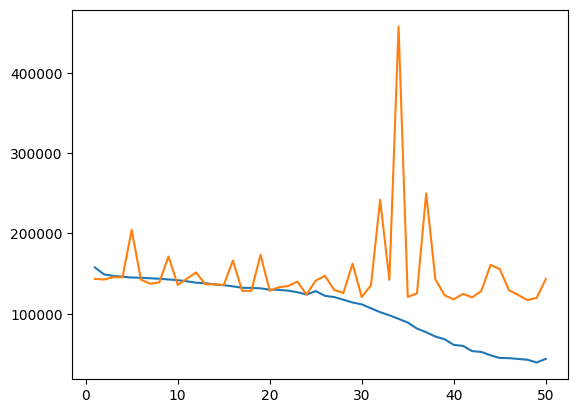

In [5]:
import matplotlib.pyplot as plt

plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, val_losses, label="Val Loss")